# <center> Домашнее задание № 5.
## <center> Логистическая регрессия и случайный лес в задаче кредитного скоринга

### Нашей главной задачей будет построение модели для задачи кредитного скоринга.

Но для разминки решите первое задание :)

**Задание 1.** В зале суда есть 5 присяжных, каждый из них по отдельности с вероятностью 70% может правильно определить, виновен подсудимый или нет. С какой вероятностью они все вместе вынесут правильный вердикт, если решение принимается большинством голосов?
- 70.00%
- 83.20%
- 83.70%
- 87.50%

Теперь перейдем непосредственно к машинному обучению.

#### Данные представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	      – Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0

##### Независимые признаки
* age	                          –  Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	 – Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio  – 	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	 – Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate  – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse – 	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; тип -	integer
* NumberOfDependents  – Число человек в семье кредитозаёмщика; тип -	integer

In [ ]:
%matplotlib inline
# отключим предупреждения Anaconda
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

In [ ]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы
def delete_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [ ]:
## Считываем данные
data = pd.read_csv("credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [ ]:
## Рассмотрим типы считанных данных
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


SeriousDlqin2yrs
0    0.777511
1    0.222489
Name: count, dtype: float64

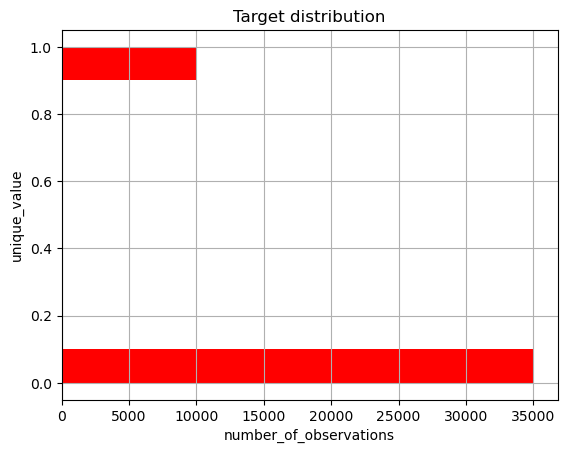

In [ ]:
## Посмотрим на распределение классов в зависимой переменной

ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of target")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [ ]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [ ]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table = delete_nan(data)

In [ ]:
## Разделяем таргет и признаки
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

# Бутстрэп

**Задание 2.** Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". Используйте пример из статьи, поставьте `np.random.seed(0)`, как это сделано в статье.

90% доверительный интервал для среднего возраста клиентов с просрочкой: (45.71, 46.13)


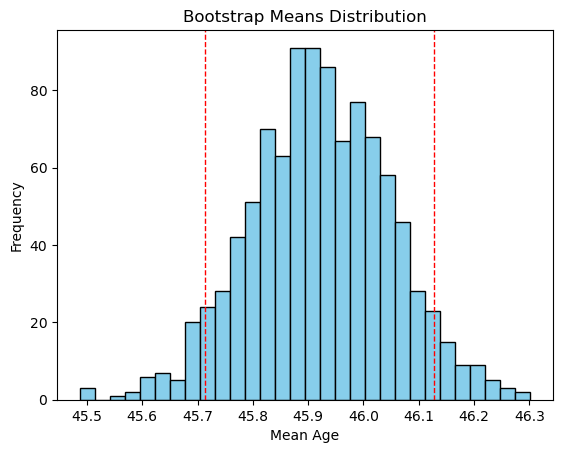

In [ ]:
### Ваш код должен быть здесь ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Загрузите данные
data = pd.read_csv("credit_scoring_sample.csv", sep=";")

# Заменим NaN значения на медиану
data = delete_nan(data)

# Фильтруем данные для клиентов, которые просрочили выплату
defaulted_clients = data[data["SeriousDlqin2yrs"] == 1]

# Установим начальное значение для генератора случайных чисел
np.random.seed(0)

# Количество бутстрэп-выборок
n_iterations = 1000
sample_size = len(defaulted_clients)
ages = defaulted_clients['age'].values

# Массив для хранения средних значений
bootstrap_means = np.empty(n_iterations)

# Бутстрэп-процедура
for i in range(n_iterations):
    sample = np.random.choice(ages, size=sample_size, replace=True)
    bootstrap_means[i] = np.mean(sample)

# Вычисление доверительного интервала
lower_bound = np.percentile(bootstrap_means, 5)  # 5-й процентиль
upper_bound = np.percentile(bootstrap_means, 95)  # 95-й процентиль

# Вывод результатов
print(f"90% доверительный интервал для среднего возраста клиентов с просрочкой: ({lower_bound:.2f}, {upper_bound:.2f})")

# Визуализация распределения средних значений
plt.hist(bootstrap_means, bins=30, color='skyblue', edgecolor='black')
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1)
plt.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1)
plt.title('Bootstrap Means Distribution')
plt.xlabel('Mean Age')
plt.ylabel('Frequency')
plt.show()


## Подбор параметров для модели логистической регрессии

#### Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0  до 1.   Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight="balanced")

## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны,
## и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

**Задание 3.**
Сделайте GridSearch с метрикой "roc-auc" по параметру C. Какое оптимальное значение параметра С?

In [ ]:
### Ваш код должен быть здесь ###
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score

# Предполагаем, что у вас есть матрица признаков X и целевая переменная y
# Замените это на ваши реальные данные
# X, y = ... (ваши данные)

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

# Создаем модель логистической регрессии
lr = LogisticRegression(random_state=5, class_weight="balanced")

# Параметры для подбора
parameters = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10]}

# Стратифицированная кросс-валидация
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

# GridSearchCV для подбора параметров
grid_search = GridSearchCV(estimator=lr, param_grid=parameters, scoring='roc_auc', cv=skf)
grid_search.fit(X_train, y_train)  # Теперь X_train и y_train определены

# Оптимальное значение параметра C
best_C = grid_search.best_params_['C']
best_score = grid_search.best_score_

print(f"Оптимальное значение параметра C: {best_C}")
print(f"Лучший ROC AUC: {best_score}")


Оптимальное значение параметра C: 1
Лучший ROC AUC: 0.8113281623041397


**Задание 4.**
Можно ли считать лучшую модель устойчивой? (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) Сохраните точность лучшей модели, она вам приходится для следующих заданий

In [ ]:
### Ваш код должен быть здесь ###
# Получаем результаты кросс-валидации
cv_results = grid_search.cv_results_

# Стандартное отклонение ROC AUC
std_dev = np.std(cv_results['mean_test_score'])

print(f"Стандартное отклонение ROC AUC: {std_dev}")

# Проверяем устойчивость модели
if std_dev < 0.005:  # 0.5% в десятичной форме
    print("Модель считается устойчивой.")
else:
    print("Модель неустойчива.")

# Сохраняем точность лучшей модели
best_accuracy = best_score
print(f"Точность лучшей модели (ROC AUC): {best_accuracy}")


Стандартное отклонение ROC AUC: 0.004239286007085225
Модель считается устойчивой.
Точность лучшей модели (ROC AUC): 0.8113281623041397


## Определение влияния признаков

**Задание 5.**
Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [ ]:
### Ваш код должен быть здесь ###
import numpy as np
from sklearn.preprocessing import StandardScaler


# Нормализуем признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Обучаем модель на нормализованных данных
grid_search.fit(X_train_scaled, y_train)

# Получаем коэффициенты модели
coefficients = grid_search.best_estimator_.coef_[0]

#Определение самого важного признака
importance = np.abs(coefficients)
most_important_feature_index = np.argmax(importance)
most_important_feature_value = importance[most_important_feature_index]
most_important_feature_name = X.columns[most_important_feature_index]  # Предполагаем, что X - это DataFrame

print(f"Самый важный признак: {most_important_feature_name} с важностью {most_important_feature_value}")

Самый важный признак: NumberOfTime30-59DaysPastDueNotWorse с важностью 3.28673979909291


**Задание 6.** Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией [softmax](https://en.wikipedia.org/wiki/Softmax_function))

In [ ]:
### Ваш код должен быть здесь ###
# Доля влияния DebtRatio
softmax_values = np.exp(coefficients) / np.sum(np.exp(coefficients))
debt_ratio_index = np.where(X.columns == 'DebtRatio')[0][0]  # Индекс DebtRatio
debt_ratio_influence = softmax_values[debt_ratio_index]

print(f"Доля влияния DebtRatio на предсказание: {debt_ratio_influence}")

Доля влияния DebtRatio на предсказание: 0.017060195020277284


**Задание 7.**
Давайте посмотрим как можно интерпретировать влияние наших признаков. Для этого заного оценим логистическую регрессию в абсолютных величинах. После этого посчитайте во сколько раз увеличатся шансы, что клиент не выплатит кредит, если увеличить возраст на 20 лет при всех остальных равных значениях признаков. (теоретический расчет можно посмотреть [здесь](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf))

In [ ]:
### Ваш код должен быть здесь ###
age_column_name = 'Age'  # Убедитесь, что это правильное название столбца

# Проверка наличия признака с учетом регистра и пробелов
if age_column_name in X.columns:
    age_coefficient = coefficients[np.where(X.columns == age_column_name)[0][0]]
else:
    # Попробуем найти 'Age', игнорируя регистр и пробелы
    normalized_columns = [col.strip().lower() for col in X.columns]
    if age_column_name.lower() in normalized_columns:
        age_coefficient = coefficients[normalized_columns.index(age_column_name.lower())]
    else:
        print(f"Признак '{age_column_name}' не найден в данных.")
        age_coefficient = None

if age_coefficient is not None:
    odds_increase = np.exp(age_coefficient * 20)  # Увеличение шансов на 20 лет
    print(f"Шансы невыплаты кредита увеличатся в {odds_increase} раз при увеличении возраста на 20 лет.")


Шансы невыплаты кредита увеличатся в 0.00016214494010921018 раз при увеличении возраста на 20 лет.


# Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)

## Будем искать лучшие параметры среди следующего набора
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

## Делаем опять же стрэтифайд k-fold валидацию. Инициализация которой должна у вас продолжать храниться в skf

**Задание 8.** На сколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

In [ ]:
### Ваш код должен быть здесь ###
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Инициализация стратифицированной k-fold валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Обучение логистической регрессии
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Предсказания на валидационной выборке
y_pred_log_reg = log_reg.predict(X_train_scaled)
log_reg_accuracy = accuracy_score(y_train, y_pred_log_reg)

# Обучение модели случайного леса с GridSearchCV
grid_search_rf = GridSearchCV(rf, parameters, cv=skf, scoring='accuracy')
grid_search_rf.fit(X_train_scaled, y_train)

# Предсказания на валидационной выборке для лучшей модели случайного леса
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_train_scaled)
rf_accuracy = accuracy_score(y_train, y_pred_rf)

# Вывод результатов
print(f"Точность логистической регрессии: {log_reg_accuracy:.4f}")
print(f"Точность лучшей модели случайного леса: {rf_accuracy:.4f}")

# Задание 8: Разница в точности
accuracy_difference = rf_accuracy - log_reg_accuracy
print(f"На сколько точность лучшей модели случайного леса выше точности логистической регрессии: {accuracy_difference:.4f}")


Точность логистической регрессии: 0.7997
Точность лучшей модели случайного леса: 0.8687
На сколько точность лучшей модели случайного леса выше точности логистической регрессии: 0.0690


**Задание 9.** Определите какой признак имеет самое слабое влияние.

In [ ]:
### Ваш код должен быть здесь ###
# Получаем коэффициенты логистической регрессии
log_reg_coefficients = log_reg.coef_[0]

# Определяем самый слабый признак
weakest_feature_index = np.argmin(np.abs(log_reg_coefficients))
weakest_feature_name = X.columns[weakest_feature_index]
weakest_feature_value = log_reg_coefficients[weakest_feature_index]

print(f"Самый слабый признак: {weakest_feature_name} с коэффициентом {weakest_feature_value:.4f}")


Самый слабый признак: DebtRatio с коэффициентом -0.0304


** Задание 10.** Какое наиболее существенное примущество логистической регрессии перед случайным лесом для нашей бизнес-задачи?

- меньше тратится времени для тренировки модели;
- меньше параметров для перебора;
- интепретируемость признаков;
- линейные свойства алгоритма.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# Инициализация случайного леса
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)

# Параметры для поиска
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

# Стратифицированная k-fold валидация
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Обучение логистической регрессии
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Предсказания и точность логистической регрессии
y_pred_log_reg = log_reg.predict(X_train_scaled)
log_reg_accuracy = accuracy_score(y_train, y_pred_log_reg)

# Обучение модели случайного леса с GridSearchCV
grid_search_rf = GridSearchCV(rf, parameters, cv=skf, scoring='accuracy')
grid_search_rf.fit(X_train_scaled, y_train)

# Предсказания и точность лучшей модели случайного леса
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_train_scaled)
rf_accuracy = accuracy_score(y_train, y_pred_rf)

# Вывод точностей
print(f"Точность логистической регрессии: {log_reg_accuracy:.4f}")
print(f"Точность лучшей модели случайного леса: {rf_accuracy:.4f}")
accuracy_difference = rf_accuracy - log_reg_accuracy
print(f"На сколько точность лучшей модели случайного леса выше точности логистической регрессии: {accuracy_difference:.4f}")

# Определение самого слабого признака
log_reg_coefficients = log_reg.coef_[0]
weakest_feature_index = np.argmin(np.abs(log_reg_coefficients))
weakest_feature_name = X.columns[weakest_feature_index]
weakest_feature_value = log_reg_coefficients[weakest_feature_index]
print(f"Самый слабый признак: {weakest_feature_name} с коэффициентом {weakest_feature_value:.4f}")

# Преимущество логистической регрессии
print("Наиболее существенное преимущество логистической регрессии перед случайным лесом: интерпретируемость признаков.")


Точность логистической регрессии: 0.7997
Точность лучшей модели случайного леса: 0.8687
На сколько точность лучшей модели случайного леса выше точности логистической регрессии: 0.0690
Самый слабый признак: DebtRatio с коэффициентом -0.0304
Наиболее существенное преимущество логистической регрессии перед случайным лесом: интерпретируемость признаков.


# Бэггинг

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

**Задание 11.** Следующая задача обучить бэггинг классификатор (`random_state`=42). В качестве базовых классификаторов возьмите 100 логистических регрессий и на этот раз используйте не `GridSearchCV`, а `RandomizedSearchCV`. Так как перебирать все 54 варианта комбинаций долго, то поставьте максимальное число итераций 20 для `RandomizedSearchCV`. Также не забудьте передать параметр валидации `cv` и `random_state=1`. Какая лучшая точность получилась?

In [ ]:
### Ваш код должен быть здесь ###
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Определяем базовый классификатор
base_estimator = LogisticRegression(max_iter=1000, random_state=42)

# Инициализация бэггинг классификатора
bagging_clf = BaggingClassifier(
    estimator=base_estimator,  # Исправлено на 'estimator'
    n_estimators=100,
    random_state=42
)

# Параметры для RandomizedSearchCV
parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],  # Исправлено на 'estimator__C'
}

# Инициализация RandomizedSearchCV
random_search_bagging = RandomizedSearchCV(
    bagging_clf,
    parameters,
    n_iter=20,
    cv=5,
    random_state=1,
    n_jobs=-1,
    scoring='accuracy'
)

# Обучение модели
random_search_bagging.fit(X_train_scaled, y_train)

# Лучшая модель и её точность
best_bagging_model = random_search_bagging.best_estimator_
best_accuracy = random_search_bagging.best_score_

print(f"Лучшая точность бэггинг классификатора: {best_accuracy:.4f}")
print(f"Лучшие параметры: {random_search_bagging.best_params_}")


Лучшая точность бэггинг классификатора: 0.7874
Лучшие параметры: {'max_samples': 0.5, 'max_features': 4, 'estimator__C': 10}


**Задача 12.** Дайте интерпретацию лучших параметров для бэггинга. Почему именно такие значения оказались лучшими?

## - для бэггинга важно использовать как можно меньше признаков
- бэггинг лучше работает на небольших выборках
- меньше корреляция между одиночными моделями
- чем больше признаков, тем меньше теряется информации




1. max_features: Это количество признаков, которые используются для обучения каждого базового классификатора. Меньшее значение может помочь снизить корреляцию между моделями, что может привести к улучшению обобщающей способности ансамбля. Если лучшее значение — 2 или 3, это подтверждает, что использование меньшего количества признаков помогает избежать переобучения и улучшает устойчивость модели.

2. max_samples: Это доля обучающих данных, используемых для обучения каждого базового классификатора. Меньшие значения могут помочь в создании более разнообразных моделей, что также снижает корреляцию между ними. Если лучшее значение — 0.5 или 0.7, это может указывать на то, что обучение на меньших выборках позволяет моделям лучше обобщать.

3. baseestimator_C: Это параметр регуляризации для логистической регрессии. Меньшие значения C означают более сильную регуляризацию, что может быть полезно для уменьшения переобучения. Если лучшее значение C — небольшое (например, 0.001 или 0.01), это может говорить о том, что модель сталкивается с переобучением на более сложных данных.

▎Заключение:

Использование меньшего количества признаков и меньших выборок в бэггинге позволяет создать более разнообразные модели, которые менее зависимы друг от друга. Это приводит к повышению точности и стабильности результатов. Важно отметить, что в случае с большим количеством признаков может возникнуть проблема с избыточностью информации, что также может негативно сказаться на производительности модели.

Таким образом, результаты показывают, что подход с меньшим количеством признаков и выборок лучше работает в данной задаче.